# Markets 360 Business Case
## LLM Powered Sentiment Analyzer for Financial News
_Author: José Andrade_

_Date: 25/02/2025_

## 1 - Config and Setup

In [ ]:
!pip install -r requirements.txt

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import time
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from openai import OpenAI
from newsapi import NewsApiClient
from dotenv import load_dotenv, find_dotenv

In [2]:
_ = load_dotenv(find_dotenv())
newsapi = NewsApiClient(api_key=os.environ['NEWS_API_KEY'])
client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.environ['OPENROUTER_API_KEY'],
)

## 2 - Data Collection

### 2.1 - Getting Financial News Articles from NewsAPI

In [3]:
def get_news_data(from_date, to_date):
    """
    This function retrieves data from NewsAPI, for a given date range. 

    Args:
    from_date (str): The start date for fetching news articles in 'YYYY-MM-DD' format.
    to_date (str): The end date for fetching news articles in 'YYYY-MM-DD' format.

    Returns:
    A dictionary with dates as keys. Each value is a list of articles.
    
    """

    article_dict = {}

    # datetime objects for loop and timedelta
    from_date = datetime.strptime(from_date, "%Y-%m-%d")
    to_date = datetime.strptime(to_date, "%Y-%m-%d")

    while from_date <= to_date:
        date_str = from_date.strftime("%Y-%m-%d") # using str for api input
        all_articles = newsapi.get_everything(q='(market sentiment OR market trends OR recession OR economic growth OR ' 
                                                 'market volatility OR bull market OR bear market OR economy health) AND (equity markets) AND ("United States")', 
                                            from_param=date_str,
                                            to=date_str,
                                            language='en',
                                            sort_by='relevancy')

        for article in all_articles["articles"]:  # list of dictionaries
            date = datetime.strptime(article["publishedAt"], "%Y-%m-%dT%H:%M:%SZ").date().isoformat() # date from output. from string to datetime object
            content = article["content"]
            if date not in article_dict:
                article_dict[date] = []  # create a new list if does not existent
            article_dict[date].append(content)
        from_date += timedelta(days=1)

    # Adding an id to each article - easier for llm batch processing
    article_id = 1  
    for date, contents in article_dict.items():
        for i in range(len(contents)):
            article_dict[date][i] = {"id": article_id, "content": contents[i]}
            article_id += 1

    return article_dict

In [4]:
# Retrieve data for the last month
#cannot get articles for today, limit is today-1
today_date = datetime.today().date()
older_date = (today_date - timedelta(days=31)).strftime("%Y-%m-%d")
recent_date = (today_date - timedelta(days=1)).strftime("%Y-%m-%d")
article_dict = get_news_data(older_date, recent_date)
print(f'Getting news data from {older_date} to {recent_date}.')

Getting news data from 2025-01-25 to 2025-02-24.


In [5]:
for date, contents in article_dict.items():
    print(f"Date: {date}, Number of articles: {len(contents)}")


Date: 2025-01-25, Number of articles: 16
Date: 2025-01-26, Number of articles: 11
Date: 2025-01-27, Number of articles: 11
Date: 2025-01-28, Number of articles: 16
Date: 2025-01-29, Number of articles: 21
Date: 2025-01-30, Number of articles: 25
Date: 2025-01-31, Number of articles: 11
Date: 2025-02-01, Number of articles: 16
Date: 2025-02-02, Number of articles: 8
Date: 2025-02-03, Number of articles: 20
Date: 2025-02-04, Number of articles: 26
Date: 2025-02-05, Number of articles: 12
Date: 2025-02-06, Number of articles: 25
Date: 2025-02-07, Number of articles: 18
Date: 2025-02-08, Number of articles: 14
Date: 2025-02-10, Number of articles: 15
Date: 2025-02-11, Number of articles: 28
Date: 2025-02-12, Number of articles: 25
Date: 2025-02-13, Number of articles: 29
Date: 2025-02-14, Number of articles: 11
Date: 2025-02-15, Number of articles: 12
Date: 2025-02-16, Number of articles: 9
Date: 2025-02-17, Number of articles: 14
Date: 2025-02-18, Number of articles: 18
Date: 2025-02-19, 

In [6]:
article_dict

{'2025-01-25': [{'id': 1,
   'content': 'Schrödinger (NASDAQ: $SDGR) uses quantum mechanics to design new medicines and materials. All top 20 pharmaceutical companies buy its software.\r\nSchrodingers SEC filings and website claim that the to… [+41094 chars]'},
  {'id': 2,
   'content': 'Equities research analysts at BMO Capital Markets began coverage on shares of CNO Financial Group (NYSE:CNO – Get Free Report) in a note issued to investors on Thursday, MarketBeat.com reports. The b… [+5675 chars]'},
  {'id': 3,
   'content': 'Crossmark Global Holdings Inc. grew its position in Sprouts Farmers Market, Inc. (NASDAQ:SFM – Free Report) by 2.4% in the fourth quarter, according to its most recent Form 13F filing with the Securi… [+6250 chars]'},
  {'id': 4,
   'content': 'MassMutual Private Wealth &amp; Trust FSB boosted its position in shares of Sprouts Farmers Market, Inc. (NASDAQ:SFM – Free Report) by 28.6% during the 4th quarter, according to its most recent 13F f… [+6164 chars]'},
  {

In [7]:
article_dict_copy = article_dict # backup

In [8]:
#article_dict = get_news_data('2025-01-27', '2025-01-29')

### 2.2 - Sentiment Analysis for News Articles 

In [ ]:
def analyze_sentiment (article_dict, max_attempts = 5):
    """
    This function analyzes recession fear sentiment of articles for a given date using an LLM.
    The LLM is prompt to classify articles with a value between 1 and -1 (where 1 = high fear, -1 = no fear)

    Args:
    article_dict (dictionary): A dictionary with a list of dictionaries. Structured as {Date:[{id:,content:}]}
    max_attemps (int): A positive integer that sets how many retries the function will make in case the llm quota is exceded - API calls are free but rate limited

    Returns:
    list: A list of dictionaries with sentiment analysis and the most related sector results per article.
    """

    # list to store llm output dictionaries
    sentiment_data = [] 


    max_attempts = max_attempts
    attempt = 1

    # Calling the llm for each key with data in the dictionary
    for date in article_dict.keys():
        
        date_attempt = 0

        if attempt < max_attempts:

            articles = article_dict.get(date, []) 
            articles_json = json.dumps(articles, indent=2)

            prompt = f"""
            Analyze the following articles and determine their sentiment score on recession fears, along with only the most relevant activity sector.

            **Output format:**
            Respond **only** with a JSON dictionary, structured as follows:  
            ```json
            [{{"id": <id>, "score": <sentiment_score>, "sector": "<sector>"}}]

            Context:
            - `id`: the article's unique ID.
            - `sentiment_score`: sentiment score on recession fears should be between 1 and -1 (where 1 = high fear, -1 = no fear).
            - `sector`: the most related activity sector in the article.

            Possible sectors: Technology, Energy, Healthcare, Finance, Retail, Manufacturing, Real Estate, Media.

            **Articles:**
            {articles_json}
            """

            
            while attempt <= max_attempts:
                try:
                    # call to OpenRouter LLM
                    llm_response = client.chat.completions.create(
                        model="google/gemini-2.0-pro-exp-02-05:free", #currently free to use, although with some rate limitations by google
                        messages=[{"role": "system", "content": "You are a financial news analyst."},
                                {"role": "user", "content": prompt}],
                        temperature=0.0
                    )
                    #print(f"FIRST: {llm_response}")
                    llm_response_content = llm_response.choices[0].message.content.strip('`json ').split('```')[0] #getting only the desirable json output #maybe change for regex
                    new_sentiment_data = json.loads(llm_response_content) #once the correct string, load it as dictionary
                    sentiment_data.extend(new_sentiment_data) #adding each new batch to main sentiment variable.
                    print(f"Sucessfully retrieved for {date} batch.")
                    attempt -= date_attempt
                    break
                except:
                    print(f"Quota exceeded. Retrying in 10 seconds... (Attempt {attempt}/{max_attempts})")
                    attempt += 1
                    date_attempt += 1
                    time.sleep(10)
        else:    
            print('Maximum attempts reached. Try again later.')
            break

    return sentiment_data

In [10]:
sentiment_data = analyze_sentiment(article_dict)

FIRST: ChatCompletion(id='gen-1740441956-xSTDhmt0KEfLVphtrbNR', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```json\n[\n  {\n    "id": 1,\n    "score": 0,\n    "sector": "Healthcare"\n  },\n  {\n    "id": 2,\n    "score": 0,\n    "sector": "Finance"\n  },\n  {\n    "id": 3,\n    "score": 0,\n    "sector": "Retail"\n  },\n  {\n    "id": 4,\n    "score": 0,\n    "sector": "Retail"\n  },\n  {\n    "id": 5,\n    "score": 0,\n    "sector": "Healthcare"\n  },\n  {\n    "id": 6,\n    "score": 0,\n    "sector": "Healthcare"\n  },\n  {\n    "id": 7,\n    "score": 0,\n    "sector": "Healthcare"\n  },\n  {\n    "id": 8,\n    "score": 0,\n    "sector": "Retail"\n  },\n  {\n    "id": 9,\n    "score": 0,\n    "sector": "Healthcare"\n  },\n  {\n    "id": 10,\n    "score": 0,\n    "sector": "Technology"\n  },\n  {\n    "id": 11,\n    "score": 0,\n    "sector": "Retail"\n  },\n  {\n    "id": 12,\n    "score": 0,\n    "sector": "Finance"\n  },\n  

### 2.3 - Getting SP500 data

In [11]:
# Getting S&P data
sp500 = yf.download('^GSPC', start=older_date, end=recent_date)
sp500 = sp500['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## 3 - Data Processing

### 3.1 - Daily Fear of Recession vs SP500

In [12]:
# Merging LLM output (sentiment_data) with the existing dictionary (article_dict)
merged_articles = {}

for date, articles in article_dict.items(): #each date, and each correspondednt list of articles in existing dict
    merged_articles[date] = [] #creating a new list for each given date
    
    for article in articles: #iterating over the list of articles
       # Find the sentiment data for the article by matching 'id'
        sentiment = next((item for item in sentiment_data if item['id'] == article['id']), None) # to match ids between article and sentiment_data  
        
        if sentiment is None:  # If no sentiment data is found for the article
            print(f"WARNING: No sentiment data found for article ID {article['id']} on {date}.")
            continue

        article['score'] = sentiment['score']
        article['sector'] = sentiment['sector']
        merged_articles[date].append(article)

In [13]:
# Calculate recession daily average sentiment scores into a new dictionary
average_scores_per_day = {} 

for date, contents in merged_articles.items():
        total_score = round(sum(article['score'] for article in contents), 2) #iterating over the list of dictionaries on contents 
        if total_score != 0:
                avg_score = round(total_score / len(contents), 3)
        else:
                avg_score = 0
        average_scores_per_day[date] = avg_score

In [14]:
# Creating a pd dataframe to build plots
df = pd.DataFrame(list(average_scores_per_day.items()), columns=['Date', 'Score'])
df['Date'] = pd.to_datetime(df['Date']) # datetime object
df = df.sort_values('Date') #sorting values chronologically

In [15]:
# "Make sure that the timeseries is “continuous” by giving the previous days context."
#       --> plotting with moving average
df['moving_avg'] = df['Score'].rolling(window=5).mean()

In [16]:
merged_df = pd.merge(df, sp500, on='Date', how='inner') # it will merge only on the days that both DFs have data. SP data is missing for weekends etc
merged_df.rename(columns={'^GSPC':'SP500'}, inplace=True)

# Homonegenizing data with MinMaxScaler
scaler = MinMaxScaler()
merged_df[['Score', 'moving_avg', 'SP500']] = scaler.fit_transform(merged_df[['Score', 'moving_avg', 'SP500']])

### 3.2 - Sector Daily Fear of Recession vs SP500

In [17]:
# Calculate recession daily average sentiment scores into a new dictionary by sector
average_scores_per_day_per_sector = {}

for date, contents in merged_articles.items():
    sector_scores = {}
    sector_counts = {}

    for article in contents:
        sector = article['sector']
        score = article['score']

        # Initialize sector if not present
        if sector not in sector_scores:
            sector_scores[sector] = 0
            sector_counts[sector] = 0

        # Accumulate scores and count articles per sector
        sector_scores[sector] += score
        sector_counts[sector] += 1
        
    # average sentiment score per sector
    sector_avg_scores = {
        sector: round(sector_scores[sector] / sector_counts[sector], 3)
        for sector in sector_scores
    }

    average_scores_per_day_per_sector[date] = sector_avg_scores

In [18]:
# converting to a list of tuples so that I can create the pd df
sectors_data_list = [ (date, sector, score)
    for date, sector_scores in average_scores_per_day_per_sector.items()
    for sector, score in sector_scores.items()
]

In [19]:
# Creating a sector pd dataframe to build plots
df_sector = pd.DataFrame(sectors_data_list, columns=['Date', 'Sector', 'Score'])
df_sector['Date'] = pd.to_datetime(df_sector['Date']) # datetime object
df_sector = df_sector.sort_values('Date') #sorting values chronologically

In [20]:
# "Make sure that the timeseries is “continuous” by giving the previous days context."
#       --> plotting with moving average
df_sector['moving_avg'] = df_sector.groupby('Sector')['Score'].transform(lambda x : x.rolling(window=5).mean()) #map-reduce approach

In [21]:
merged_df_sector = pd.merge(df_sector, sp500, on='Date', how='inner') # it will merge only on the days that both DFs have data. SP data is missing for weekends etc
merged_df_sector.rename(columns={'^GSPC':'SP500'}, inplace=True)

# Homonegenizing data with MinMaxScaler
scaler = MinMaxScaler()
merged_df_sector[['Score', 'moving_avg', 'SP500']] = scaler.fit_transform(merged_df_sector[['Score', 'moving_avg', 'SP500']])
merged_df_sector

,Date,Sector,Score,moving_avg,SP500
0,2025-01-27,Finance,0.309286,NaN,0.118398
1,2025-01-27,Technology,0.642857,NaN,0.118398
2,2025-01-27,Healthcare,0.125000,NaN,0.118398
3,2025-01-27,Retail,0.214286,NaN,0.118398
4,2025-01-27,Real Estate,0.000000,NaN,0.118398
...,...,...,...,...,...
98,2025-02-20,Retail,0.428571,0.430620,0.821969
99,2025-02-21,Energy,0.357143,0.451708,0.124081
100,2025-02-21,Finance,0.357143,0.557149,0.124081
101,2025-02-21,Retail,0.357143,0.388444,0.124081


## 4 - Data Exploration & Visualization

### 4.1 - Daily Fear of Recession vs SP500

In [22]:
correlation_matrix = merged_df.corr()
print(correlation_matrix) 

                Date     Score  moving_avg     SP500
Date        1.000000  0.295978    0.710101  0.554131
Score       0.295978  1.000000    0.275822  0.395178
moving_avg  0.710101  0.275822    1.000000  0.617675
SP500       0.554131  0.395178    0.617675  1.000000


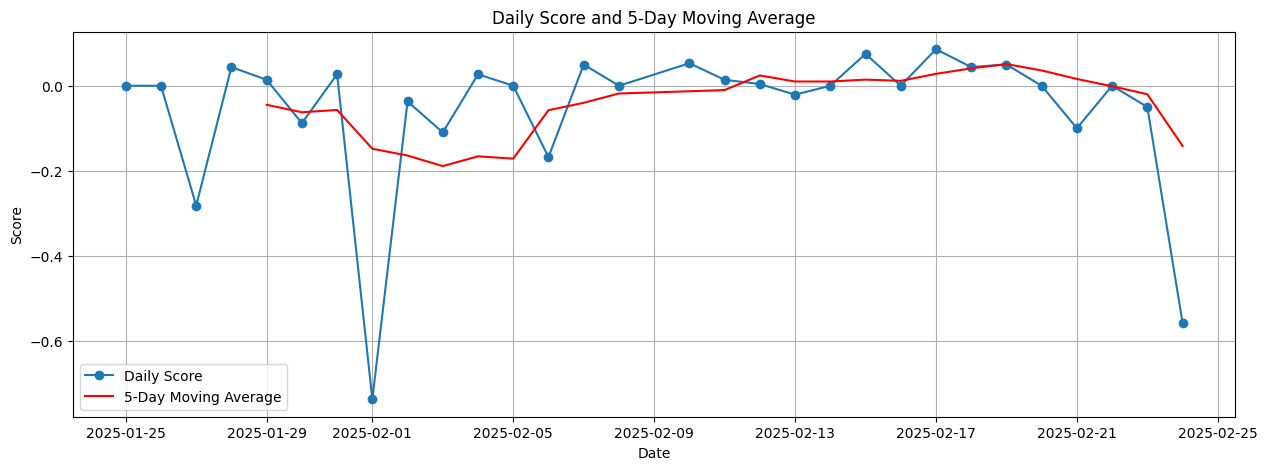

In [23]:
# Plotting sentiment score with moving average over time

plt.figure(figsize=(15, 5))
plt.plot(df['Date'], df['Score'], label='Daily Score', marker='o', linestyle='-')
plt.plot(df['Date'], df['moving_avg'], label='5-Day Moving Average', color='red')
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Daily Score and 5-Day Moving Average')
plt.legend()
plt.grid(True)
plt.show()

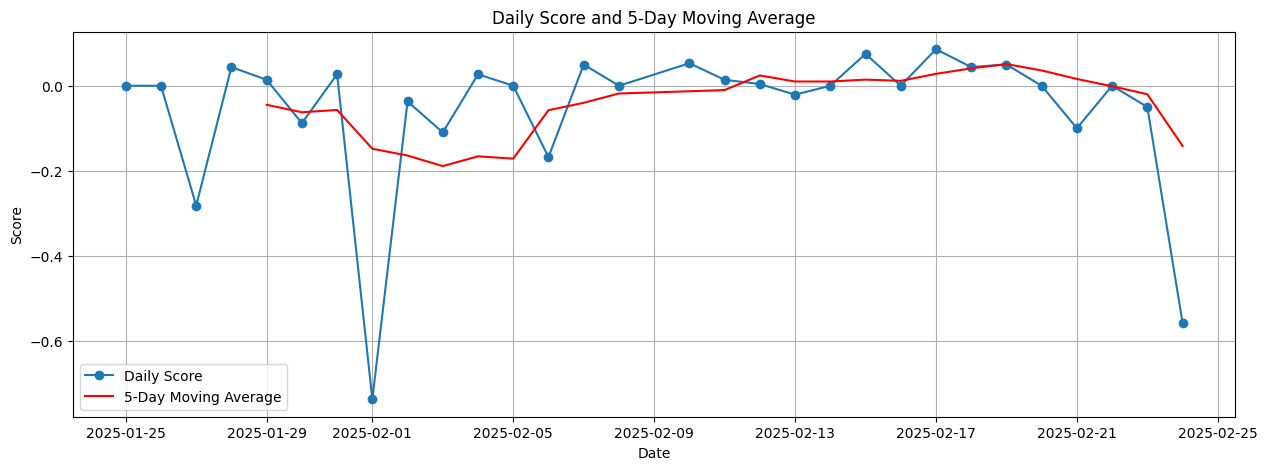

In [24]:
# Plotting sentiment score with moving average over time

plt.figure(figsize=(15, 5))
plt.plot(df['Date'], df['Score'], label='Daily Score', marker='o', linestyle='-')
plt.plot(df['Date'], df['moving_avg'], label='5-Day Moving Average', color='red')
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Daily Score and 5-Day Moving Average')
plt.legend()
plt.grid(True)
plt.show()

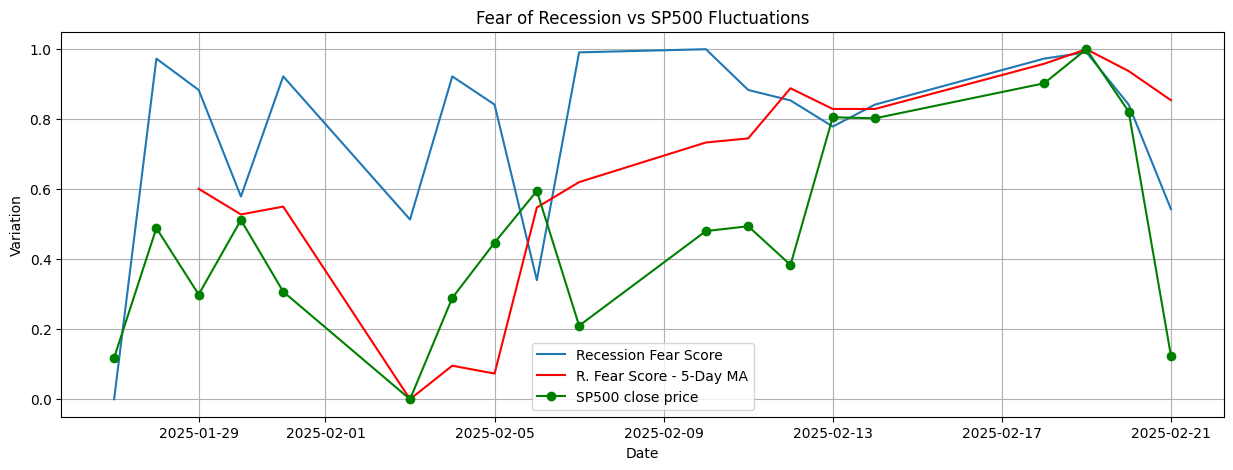

In [25]:
# Plotting sentiment score with moving average over time

plt.figure(figsize=(15, 5))
plt.plot(merged_df['Date'], merged_df['Score'], label='Recession Fear Score')
plt.plot(merged_df['Date'], merged_df['moving_avg'], label='R. Fear Score - 5-Day MA', color='red')
plt.plot(merged_df['Date'], merged_df['SP500'], label='SP500 close price', color='green', marker='o')
plt.xlabel('Date')
plt.ylabel('Variation')
plt.title('Fear of Recession vs SP500 Fluctuations')
plt.legend()
plt.grid(True)
plt.show()

### 4.2 - Sector Daily Fear of Recession vs SP500

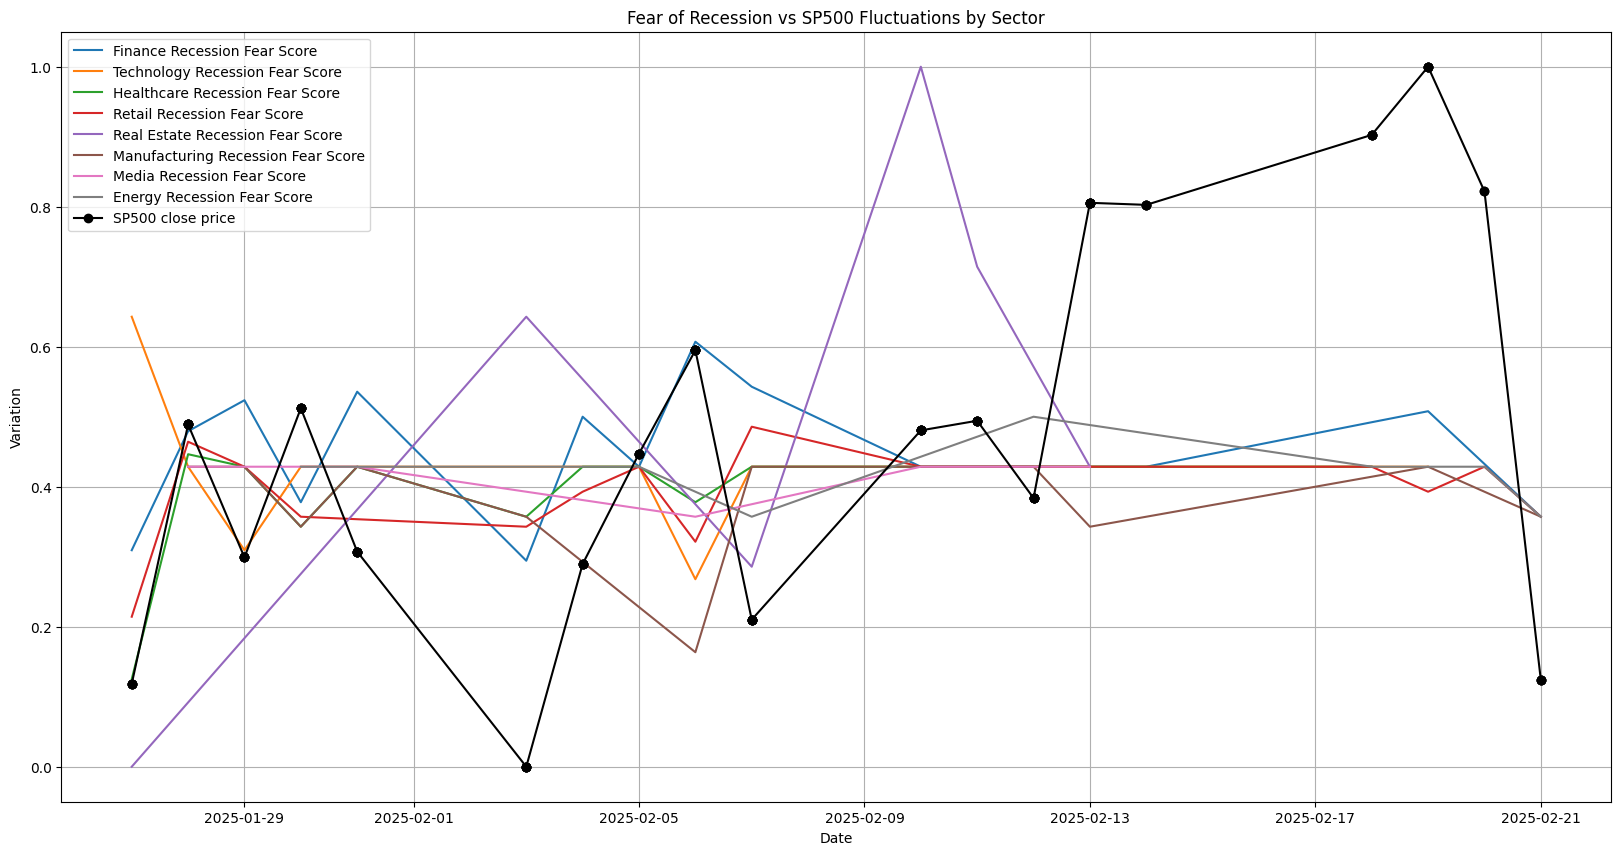

In [26]:
# Plotting sentiment score over time

plt.figure(figsize=(20, 10))

# plt for each unique sector
for sector in merged_df_sector['Sector'].unique():
    sector_data = merged_df_sector[merged_df_sector['Sector'] == sector]
    #plt.plot(sector_data['Date'], sector_data['Score'], label=f'{sector} Score')
    plt.plot(sector_data['Date'], sector_data['Score'], label=f'{sector} Recession Fear Score')

plt.plot(merged_df_sector['Date'], merged_df_sector['SP500'], label='SP500 close price', color='black', marker='o')
plt.xlabel('Date')
plt.ylabel('Variation')
plt.title('Fear of Recession vs SP500 Fluctuations by Sector')
plt.legend()
plt.grid(True)
plt.show()

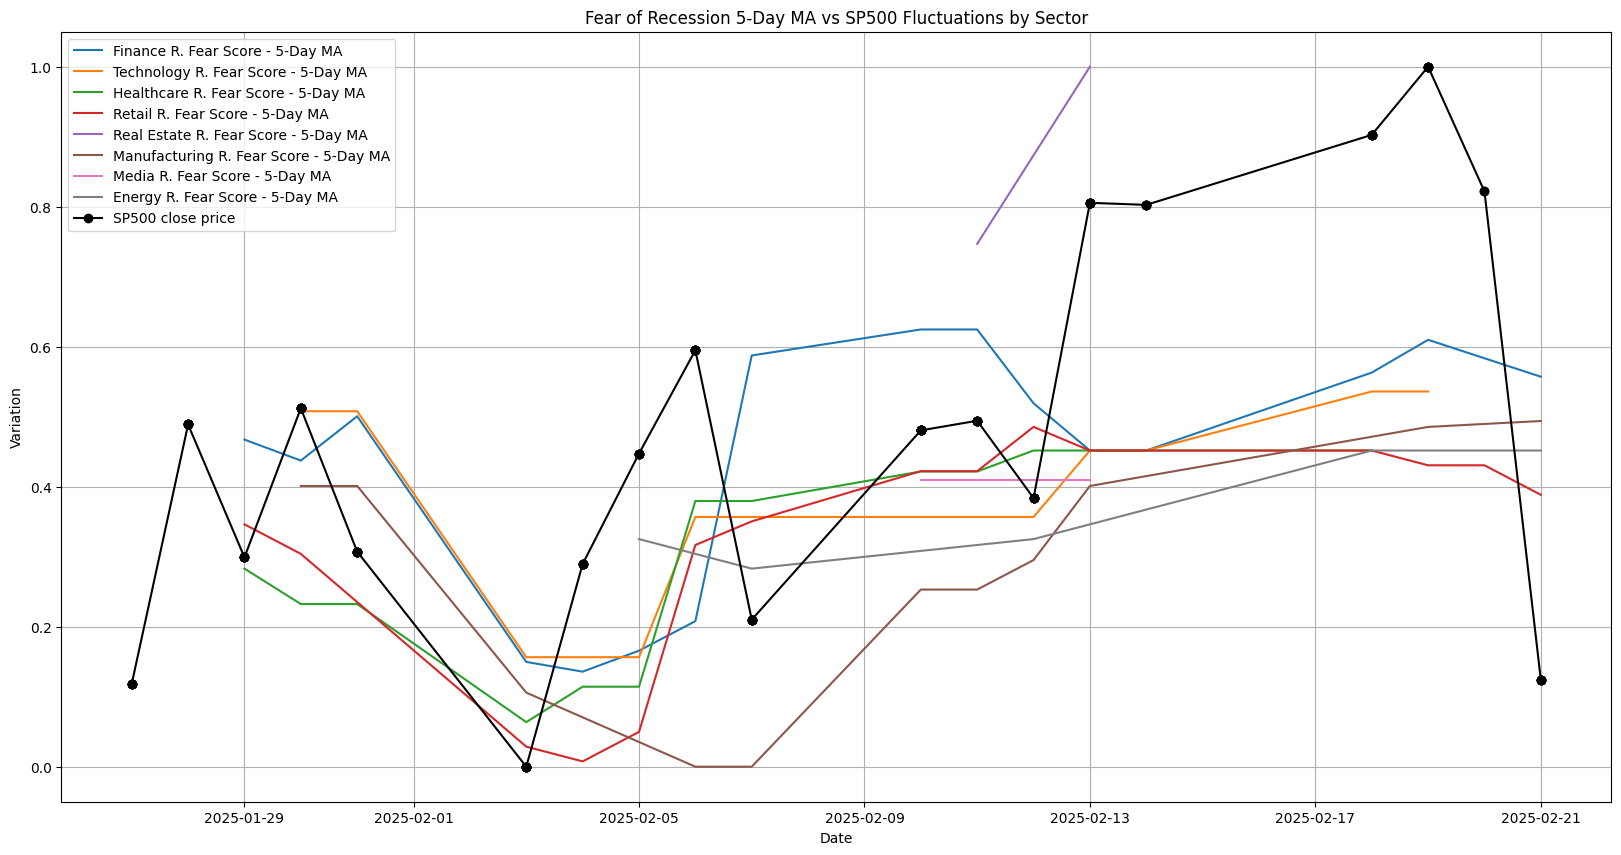

In [27]:
# Plotting sentiment score with moving average over time

plt.figure(figsize=(20, 10))

# plt for each unique sector
for sector in merged_df_sector['Sector'].unique():
    sector_data = merged_df_sector[merged_df_sector['Sector'] == sector]
    #plt.plot(sector_data['Date'], sector_data['Score'], label=f'{sector} Score')
    plt.plot(sector_data['Date'], sector_data['moving_avg'], label=f'{sector} R. Fear Score - 5-Day MA')

plt.plot(merged_df_sector['Date'], merged_df_sector['SP500'], label='SP500 close price', color='black', marker='o')
plt.xlabel('Date')
plt.ylabel('Variation')
plt.title('Fear of Recession 5-Day MA vs SP500 Fluctuations by Sector')
plt.legend()
plt.grid(True)
plt.show()

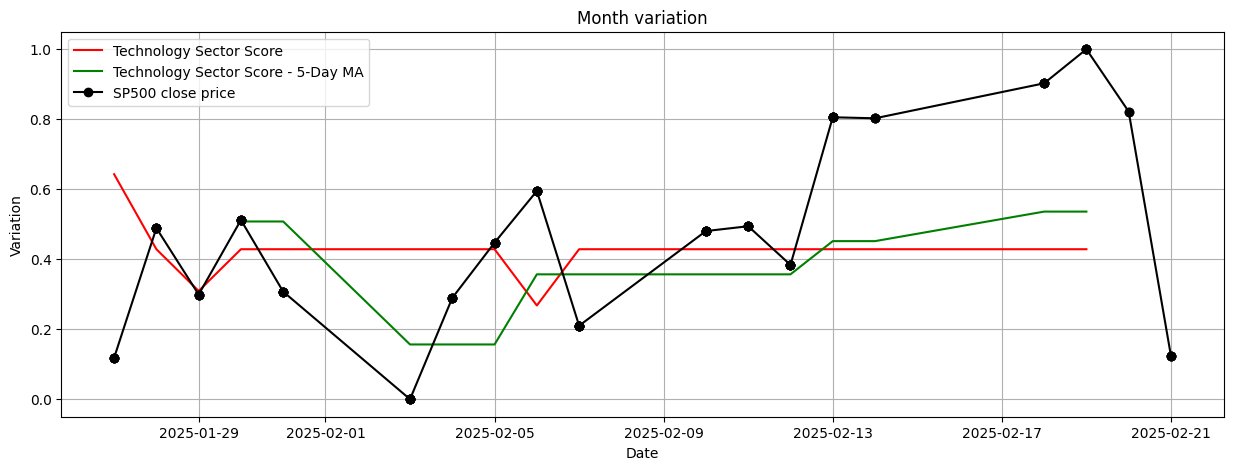

In [28]:
# Plotting sentiment score only for the tech sector

tech_data = merged_df_sector[merged_df_sector['Sector'] == 'Technology']

plt.figure(figsize=(15, 5))


plt.plot(tech_data['Date'], tech_data['Score'], label='Technology Sector Score', color='red')
plt.plot(tech_data['Date'], tech_data['moving_avg'], label='Technology Sector Score - 5-Day MA', color='green')
plt.plot(merged_df_sector['Date'], merged_df_sector['SP500'], label='SP500 close price', color='black', marker='o')
plt.xlabel('Date')
plt.ylabel('Variation')
plt.title('Month variation')
plt.legend()
plt.grid(True)
plt.show()

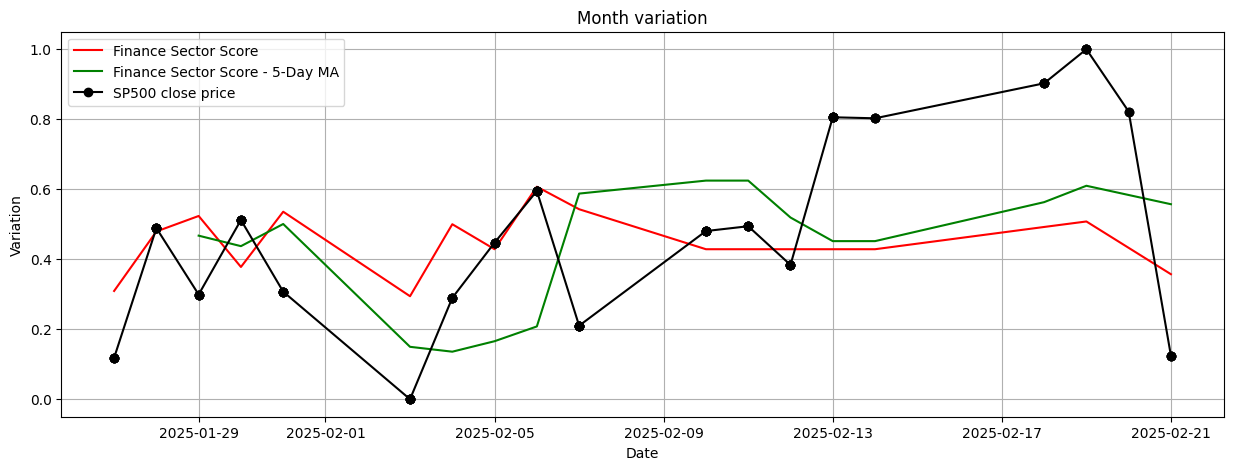

In [29]:
# Plotting sentiment score only for the finance sector

finance_data = merged_df_sector[merged_df_sector['Sector'] == 'Finance']

plt.figure(figsize=(15, 5))


plt.plot(finance_data['Date'], finance_data['Score'], label='Finance Sector Score', color='red')
plt.plot(finance_data['Date'], finance_data['moving_avg'], label='Finance Sector Score - 5-Day MA', color='green')
plt.plot(merged_df_sector['Date'], merged_df_sector['SP500'], label='SP500 close price', color='black', marker='o')
plt.xlabel('Date')
plt.ylabel('Variation')
plt.title('Month variation')
plt.legend()
plt.grid(True)
plt.show()

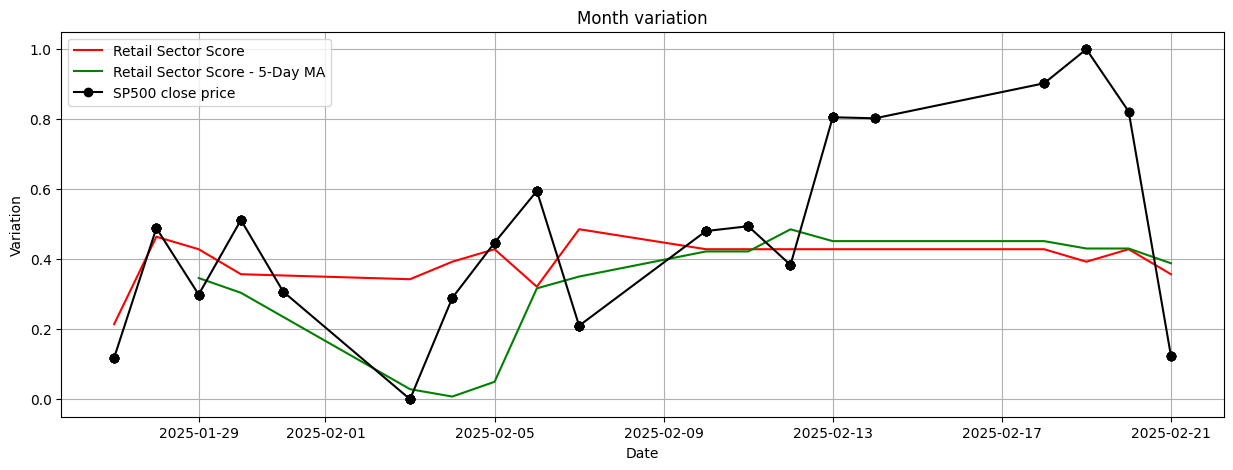

In [30]:
# Plotting sentiment score only for the Retail sector

retail_data = merged_df_sector[merged_df_sector['Sector'] == 'Retail']

plt.figure(figsize=(15, 5))


plt.plot(retail_data['Date'], retail_data['Score'], label='Retail Sector Score', color='red')
plt.plot(retail_data['Date'], retail_data['moving_avg'], label='Retail Sector Score - 5-Day MA', color='green')
plt.plot(merged_df_sector['Date'], merged_df_sector['SP500'], label='SP500 close price', color='black', marker='o')
plt.xlabel('Date')
plt.ylabel('Variation')
plt.title('Month variation')
plt.legend()
plt.grid(True)
plt.show()